## High Tide Flooding:  API Data Retrieval and Creating a Multi-Year Heatmap

Contact User Services: tide.predictions@noaa.gov

Coastal Hazards Branch

Oceanographic Division

NOAA's Center for Operational Oceanographic Products and Services (CO-OPS)

Last updated on: 7/15/2025

We will be using the Center for Operational Oceanographic Products and Services (CO-OPS) Derived Product API (DPAPI)

Input and output documentation can be found in the [CO-OPS Data API](https://api.tidesandcurrents.noaa.gov/api/prod/), [CO-OPS Derived Product API v0.1](https://api.tidesandcurrents.noaa.gov/dpapi/prod/) and the [CO-OPS Metadata API](https://api.tidesandcurrents.noaa.gov/mdapi/prod/).


Standard templates are available within the [CO-OPS API URL Builder](https://tidesandcurrents.noaa.gov/api-helper/url-generator.html), but this notebook is designed to give you more flexiblity through building our own API template to generate queries from our Data API, MetaData API, and Derived Product API.

 #### Plot concept provided by:

*Brian McNoldy*, bmcnoldy@rsmas.miami.edu  
*University of Miami's Rosenstiel School of Marine and Atmospheric Science*

#### You'll need the following packages to plot each visualization.

In [1]:
import datetime as dt
import requests
import time as time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### The following variables are used to pull data from the API. 

In [2]:
station_id = '8723214'
product='floodlevels'
units='english'
product2 = 'datums'
product3 = 'hourly_height'
datum = 'MHHW'

#### This step creates a template, pulls National Ocean Service (NOS) flooding thresholds from the metadata API, then creates a dataframe.  

In [3]:
#grab nos thresholds

server = 'https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/'

my_url = (server+'stations/'+station_id+'/'+product+'.json?units='+units)


urlResponse = requests.get(my_url)
content=urlResponse.json()

thresh = pd.DataFrame({'Minor':[content['nos_minor']],'Moderate':[content['nos_moderate']],'Major':[content['nos_major']]})

#### This step creates a template, pulls datums from the metadata API, then assigns a variable. 

In [4]:
#grab datums

server = 'https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/'
my_url = (server+'stations/'+station_id+'/'+product2+'.json?units='+units)

urlResponse = requests.get(my_url)
content=urlResponse.json()

MHHW = content['datums'][1]['value']

#### Now, we rearrange variables and assign them to a list to loop through years and fill gaps where needed. 

#### NOTE: The 'time.sleep(5)' function puts 5 seconds between each api data call to keep it from crashing.

In [5]:
# yr_list = np.arange(2019,2021,1).tolist()
yr_list=np.arange(1994,2023,1).tolist()

df_all=pd.DataFrame()
key='error'
for yr in yr_list:
    year = str(yr)
    server='https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?'
    url=(server+'begin_date='+year+'0101&end_date='+year+'1231&station='+station_id+'&product='+product3+'&datum='+datum+'&time_zone=gmt&units='+units+'&format=json')

    urlResponse = requests.get(url)
    content=urlResponse.json()
    
    
    if next(iter(content)) == 'error':
        df=pd.DataFrame()
        date_range = pd.date_range(year+'0101', year+'1231',freq='1H')
        vals = np.full((len(date_range),1),np.nan)
        
        dt = pd.DataFrame({'datetime':date_range,'hh':vals[:,0]})
        df=df.append(dt,ignore_index=True)
    else:
        data = np.array ([[aTime['t'], aTime['v']] for aTime in content['data']]).T
        df = pd.DataFrame ({'datetime': data[0], 'hh': data[1]})
        
        df['datetime'] = pd.to_datetime(df['datetime'])
        
        df['hh'] = pd.to_numeric(df['hh'])
    
    
    df_all = pd.concat([df_all, df], ignore_index=True)


time.sleep(5)

#### This step pulls station ID and station name from the metadata key in the data API content. 

In [6]:
#define station ID and name
stn_id=content['metadata']['id']
stn_name = content['metadata']['name']

#### Now, we convert NOS thresholds to the Mean Higher High Water (MHHW) datum - this step is taken because we pulled water level data on MHHW in the beginning. 

In [7]:
#find where WL is greater than the threshold
df=df_all

thresh_min = (thresh['Minor'][0]-MHHW)#need to subtract MHHW because the nos threshold is on STND
thresh_mod = (thresh['Moderate'][0]-MHHW)
thresh_maj = (thresh['Major'][0]-MHHW)

thresh_zero = 0

#### This step determines where the data is above the threshold, then assigns them a '1' if it's true and '0' if it's false. NaNs were placed in each column where the original data shows NaN (Eg. column hh).

In [8]:
df['min_c']=np.where(df['hh']>=thresh_min,1,0)
df['mod_c']=np.where(df['hh']>=thresh_mod,1,0)
df['maj_c']=np.where(df['hh']>=thresh_maj,1,0)
df['zero_c']=np.where(df['hh']>=thresh_zero,1,0)


df['min_c']=df['min_c'].mask(df['hh'].isna())
df['mod_c']=df['mod_c'].mask(df['hh'].isna())
df['maj_c']=df['maj_c'].mask(df['hh'].isna())
df['zero_c']=df['zero_c'].mask(df['hh'].isna())


df = df.set_index('datetime')

#### This cell regroups the information by year, month, and day in order to get a daily count. 

In [9]:
#groupby to get the hours/day count
gg= df.groupby([df.index.year,df.index.month,df.index.day])

mincounts = []
modcounts = []
majcounts = []
zercounts = []
date = []

for gname in gg.groups.keys():
    gp = gg.get_group(gname)
    # print(gp.index[0])
    # print(gp['y'].sum())
    mincounts.append(gp['min_c'].sum(skipna=False))
    modcounts.append(gp['mod_c'].sum(skipna=False))
    majcounts.append(gp['maj_c'].sum(skipna=False))
    zercounts.append(gp['zero_c'].sum(skipna=False))
    date.append(gp.index[0])

    
dff=pd.DataFrame({'Date':date,'Min_Count':mincounts,'Mod_Count':modcounts,'Maj_Count':majcounts,'Zero_Count':zercounts})

dff['Date'] = pd.to_datetime(dff['Date'])


dff=dff.set_index('Date')

#### Now, all counts for minor, moderate, major, and zero flooding days are collected, then the table is pivoted to allign data for mapping. 

In [ ]:
#create additional columns in order to pivot the table
dff['year'] = dff.index.year
dff['month'] = dff.index.month
dff['day'] = dff.index.day

dff['mon_day'] = dff.index.strftime('%m-%d')
k=dff.reset_index()

my_cols = ['Min_Count','Mod_Count','Maj_Count','Zero_Count']
hr_counts = k.pivot(index='mon_day', columns='year', values=my_cols)


#### This step creates a heatmap of flooding hours per day above zero, for a specific threshold.

Text(0.5, 1.0, 'Hours/Day with Water Level $\\geq\\ $0ft MHHW \n at 8723214, Virginia Key')

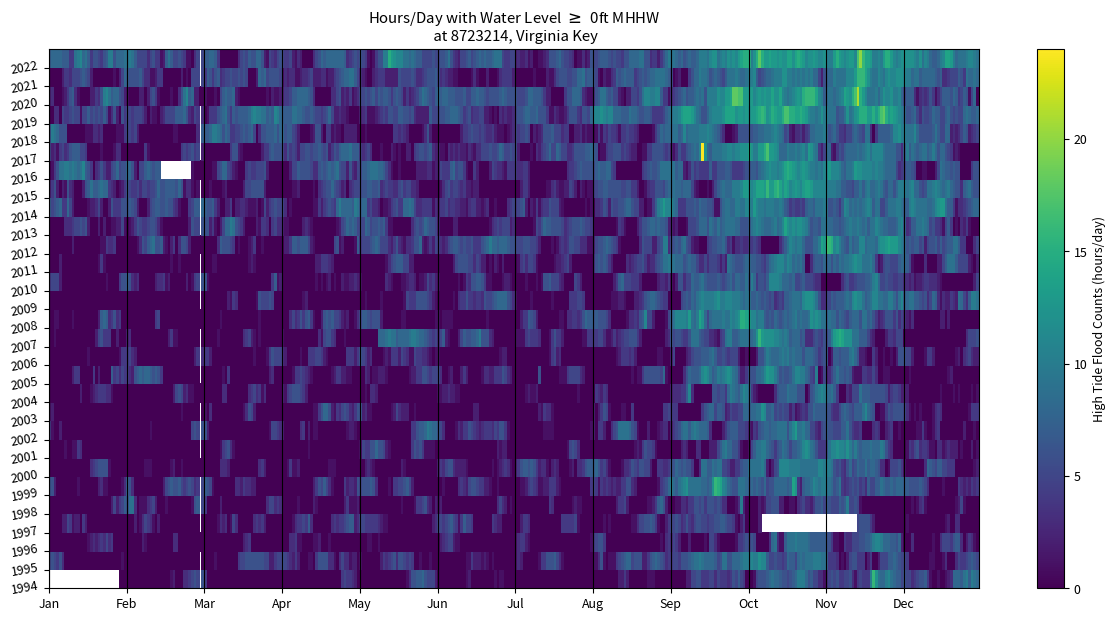

In [12]:
#create a heatmap to show hours/day: years on the y axis, month-day on the x axis
xtic = np.arange(1,340,30)

plt.figure(figsize=(15,7))
plt.pcolor(hr_counts['Zero_Count'].T,cmap='viridis',vmin=0,vmax=np.nanmax(hr_counts.values))
plt.colorbar(label='High Tide Flood Counts (hours/day)')
plt.grid(color='black',axis='x')

plt.xticks(xtic,labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlim(1,360)


ytic=np.arange(0,len(hr_counts['Min_Count'].columns),1)

plt.yticks(ytic,labels=hr_counts['Min_Count'].columns,rotation=10,va='center')



plt.title('Hours/Day with Water Level ' +r'$\geq\ $0ft' +' MHHW \n at '+ stn_id+', '+stn_name)

#### This step is just like the previous one, but plots data with the NOS flooding thresholds. 

Text(0.5, 1.0, 'Hours/Day with Water Level Above NOS Minor Threshold \n at 8723214, Virginia Key')

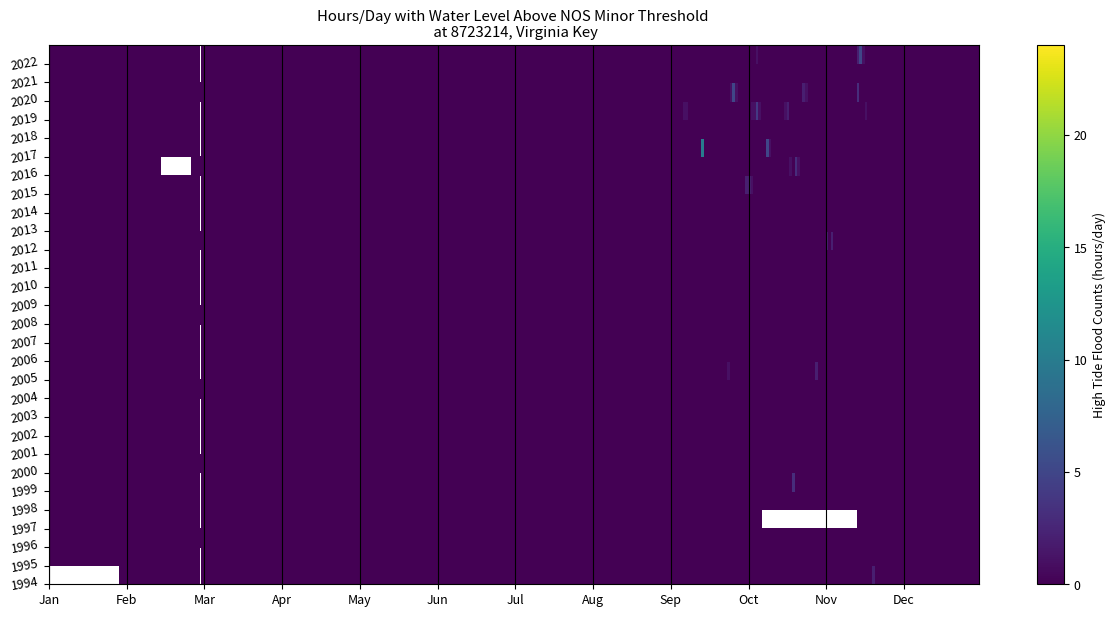

In [13]:
#create a heatmap to show hours/day: years on the y axis, month-day on the x axis
xtic = np.arange(1,340,30)

plt.figure(figsize=(15,7))
plt.pcolor(hr_counts['Min_Count'].T,cmap='viridis',vmin=0,vmax=np.nanmax(hr_counts.values))
plt.colorbar(label='High Tide Flood Counts (hours/day)')
plt.grid(color='black',axis='x')

plt.xticks(xtic,labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlim(1,360)


ytic=np.arange(0,len(hr_counts['Min_Count'].columns),1)

plt.yticks(ytic,labels=hr_counts['Min_Count'].columns,rotation=10,va='center')



plt.title('Hours/Day with Water Level Above NOS Minor Threshold \n at '+ stn_id+', '+stn_name)

#### This step pulls data into a new dataframe to get monthly data counts based on daily maxes from the DPAPI.  Adding "startD" and "endD" allows you to plot data against each other within the same timeframe. 

In [14]:
#grab monthly HTF stats from DPAPI
# startD = '19940101'
startD = str(yr_list[0])+'0101'
# endD = '20220201'
endD = str(yr_list[-1])+'0201'

url=('https://api.tidesandcurrents.noaa.gov/dpapi/prod/webapi/htf/htf_monthly.json?station='+station_id+'&start_date='+startD+'&end_date='+endD+'&units='+units)

urlResponse = requests.get(url)
content=urlResponse.json()

data=content['MonthlyFloodCount']

df=pd.DataFrame(data)

#### This step again pivots the data to allign data for mapping. 

In [16]:
month_counts = df.pivot(index='month', columns='year', values='minCount')

#### This step creates a similar heatmap to the previous one, but this time, we're plotting days of flooding per month above a threshold. 

Text(0.5, 1.0, 'High Tide Flooding Counts (Days/Month) - Minor Threshold \n at 8723214, Virginia Key')

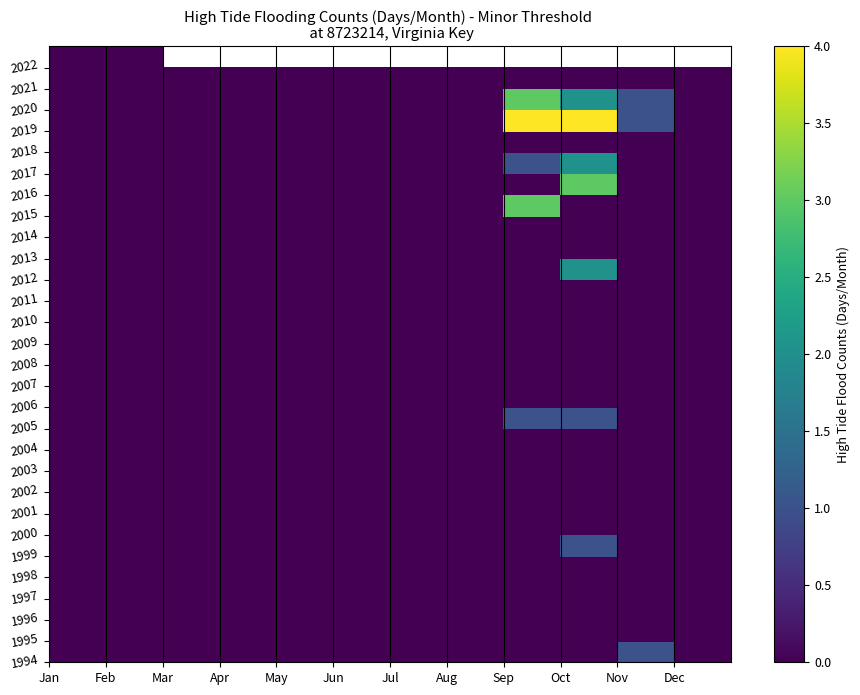

In [17]:
plt.figure(figsize=(11,8))

plt.pcolor(month_counts.T,cmap='viridis',vmin=0,vmax=np.nanmax(month_counts.values))
xtic = np.arange(0,12,1)
plt.xlim(1,12)


plt.colorbar(label='High Tide Flood Counts (Days/Month)')
plt.grid(color='black',axis='x')

plt.xticks(xtic,labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])



ytic=np.arange(0,len(month_counts.columns),1)

plt.yticks(ytic,labels=month_counts.columns,rotation=10,va='center')


plt.title('High Tide Flooding Counts (Days/Month) - Minor Threshold \n at '+ stn_id+', '+stn_name)
